In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cnx = sqlite3.connect('Database/Civ6CitySettledData.db')
cur = cnx.cursor()
print(cnx)
print(cur)

## Retrieve the city growth and performance data
cityPerTurnView contains all the relevant data captured for each city per turn of the game. I align the number of turns the city has existed so we can make an elapsed turn based evaluation.

The base identity for this database is the cityId. That is, in this database (and experiment) is designed to look at city growth over time. The same cityName can occur in multiple games so when we add the recorded information for the game we create new cityIds.

In [3]:
sqlSelect = 'SELECT * FROM cityPerTurnView WHERE turns >= 1 and turns <= 50'
cityPt = pd.read_sql_query(sqlSelect, cnx)
# Did the following directly in the database query ;-)
#cptv = cptv[cptv['turns'].between(1, 50, inclusive=True)]
print(cityPt.shape)
print(cityPt.dtypes)

(12400, 29)
cityId                 int64
gameId                 int64
settledById            int64
currentOwnerId         int64
cityName              object
settledByName         object
settledByCiv          object
currentOwnerName      object
currentOwnerCiv       object
settledOnTurn          int64
gameTurn               int64
turns                  int64
foodPerTurn          float64
foodToolTip           object
productionPerTurn    float64
productionToolTip     object
goldPerTurn          float64
goldToolTip           object
sciencePerTurn       float64
scienceToolTip        object
culturePerTurn       float64
cultureToolTip        object
faithPerTurn         float64
faithToolTip          object
population             int64
housing                int64
amenities              int64
amenitiesNeeded        int64
happiness             object
dtype: object


In [4]:
def showYieldMetrics(yld, topBottomN):
    columnName = "{}PerTurn".format(yld.lower())
    cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                                 columns='cityId',
                                                                 values=columnName).cumsum()
    t50 = cumulativeDf.loc[50]

    print("\n{}:-\nsummary statistics:".format(yld))
    print("     max: {:.2f}".format(t50.max()))
    print("     min: {:.2f}".format(t50.min()))
    print("    mean: {:.2f}".format(t50.mean()))
    print("  median: {:.2f}".format(t50.median()))
    print("     std: {:.2f}".format(t50.std()))
    print("\nQuantiles:")
    print(pd.DataFrame(t50.quantile([.2, .4, .6, .8])).T)
    print("\n")

    topN = pd.DataFrame(list(zip(list(t50.nlargest(topBottomN).values),
                                list(t50.nlargest(topBottomN).index.values)
                            )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
    bottomN = pd.DataFrame(list(zip(list(t50.nsmallest(topBottomN).values),
                                    list(t50.nsmallest(topBottomN).index.values)
                               )
                          ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), tight_layout=True)

    cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
    axes[0].set_xlabel('Turns since settled')
    axes[0].set_ylabel("{} (cumulative)".format(yld))

    t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
    axes[1].set_xlabel("Total {} by turn 50".format(yld))

    t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
    axes[2].set_xlabel('Distribution at turn 50')

    plt.show()
    plt.close()

    # Redefining t50 to be the last per turn rows in the dataframe!
    t50 = cityPt[cityPt['turns'] == 50]
    tCitiesDf = topN.set_index('cityId').join(t50.set_index('cityId'))
    bCitiesDf = bottomN.set_index('cityId').join(t50.set_index('cityId'))

    yld = yld.lower()
    print("\nTop {} {} cities:".format(topBottomN, yld))
    print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                     'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
    print("\n\nBottom {} {} cities:".format(topBottomN, yld))
    print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                     'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

## Food


Food:-
summary statistics:
     max: 804.00
     min: 186.00
    mean: 426.36
  median: 421.50
     std: 134.52

Quantiles:
      0.2    0.4    0.6    0.8
50  297.8  384.6  454.4  530.2




C:\Users\leon\Miniconda3\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


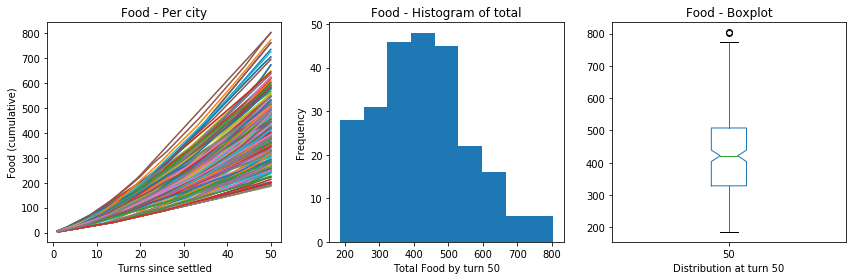


Top 10 food cities:
        foodTotal  foodPerTurn         settledByName  population  housing  \
cityId                                                                      
206         804.0         22.0  Frederick Barbarossa           7        8   
156         802.0         20.0                Kumasi           7        9   
232         774.0         20.0          Chandragupta           6        9   
91          762.0         21.0             Jerusalem           7        8   
106         762.0         21.0             Jerusalem           7        8   
41          736.0         20.0                Muscat           7        8   
150         727.0         20.0          Mohenjo-Daro           7       10   
96          705.0         16.0                 Peter           6        7   
111         705.0         16.0                 Peter           6        7   
146         695.0         18.0       Mvemba a Nzinga           6       11   

         happiness                                    

In [5]:
showYieldMetrics('Food', 10)

## Production


Production:-
summary statistics:
     max: 738.80
     min: 73.65
    mean: 302.90
  median: 203.43
     std: 188.57

Quantiles:
       0.2     0.4    0.6     0.8
50  135.52  181.19  280.5  506.39




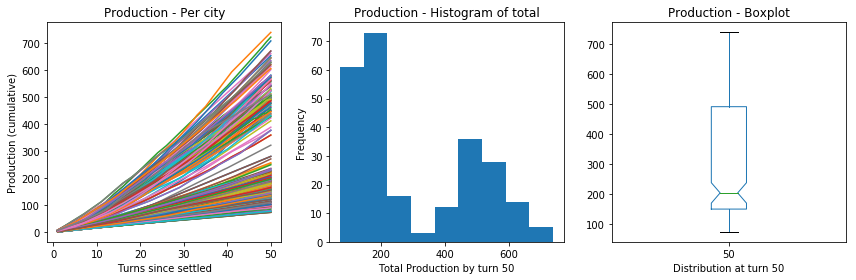


Top 10 production cities:
        productionTotal  productionPerTurn         settledByName  population  \
cityId                                                                         
132              738.80              16.25              Seondeok           4   
83               721.20              17.25  Frederick Barbarossa           5   
191              707.15              18.00             Alexander           5   
146              670.20              16.80       Mvemba a Nzinga           6   
145              669.15              19.20              Pericles           5   
67               660.20              14.40              Pericles           4   
131              652.65              15.60       Mvemba a Nzinga           5   
158              644.50              16.80        Jayavarman VII           6   
84               644.40              16.80             Philip II           5   
99               644.40              16.80             Philip II           5   

        hous

In [6]:
showYieldMetrics('Production', 10)

## Gold


Gold:-
summary statistics:
     max: 739.30
     min: 246.75
    mean: 334.77
  median: 301.25
     std: 102.95

Quantiles:
       0.2     0.4     0.6     0.8
50  257.25  281.39  312.76  387.36




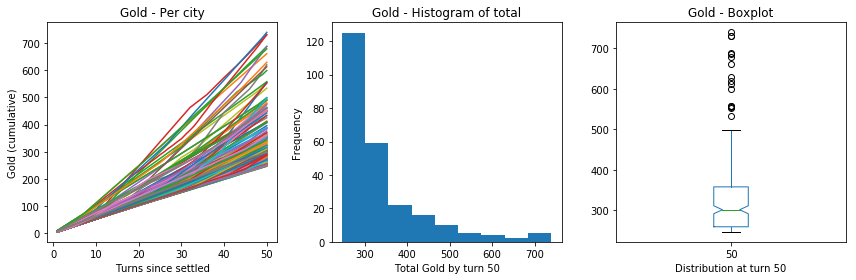


Top 10 gold cities:
        goldTotal  goldPerTurn    settledByName  population  housing  \
cityId                                                                 
131        739.30        19.20  Mvemba a Nzinga           5        8   
24         731.20        21.25  Harald Hardrada           2        6   
54         730.20        16.25       Poundmaker           5        6   
23         687.80        16.25         Seondeok           5        7   
25         687.05        21.60           Trajan           5        7   
143        678.45        14.40        Philip II           3        7   
2          660.70        13.75        Montezuma           4        8   
232        629.10        16.80     Chandragupta           6        9   
68         619.65        23.75     Genghis Khan           4        8   
116        612.55        15.00    Hojo Tokimune           4        6   

       happiness                                        goldToolTip  
cityId                                      

In [7]:
showYieldMetrics('Gold', 10)

## Science


Science:-
summary statistics:
     max: 358.02
     min: 150.22
    mean: 193.75
  median: 184.13
     std: 39.40

Quantiles:
       0.2      0.4     0.6      0.8
50  166.26  176.868  189.44  207.922




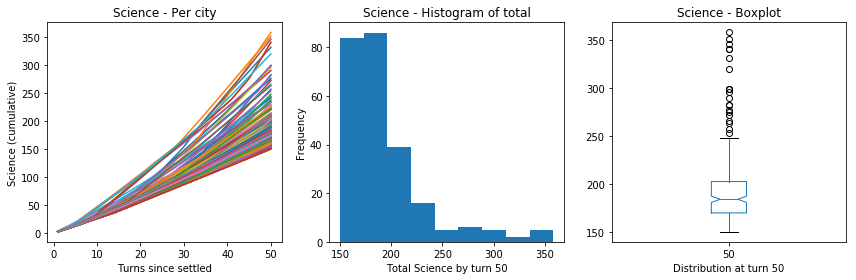


Top 10 science cities:
        scienceTotal  sciencePerTurn         settledByName  population  \
cityId                                                                   
132           358.02           11.30              Seondeok           4   
192           351.23            9.18               Jadwiga           5   
206           346.27            9.78  Frederick Barbarossa           7   
159           340.31           12.96             Gilgamesh           6   
174           340.31           12.96             Gilgamesh           6   
71            331.38            8.47             Gilgamesh           3   
220           319.62            7.91                 Gorgo           4   
205           299.53            9.18               Gitarja           5   
86            298.58            8.47       Mvemba a Nzinga           7   
101           298.58            8.47       Mvemba a Nzinga           7   

        housing   happiness                                     scienceToolTip  
cityId

In [8]:
showYieldMetrics('Science', 10)

## Culture


Culture:-
summary statistics:
     max: 297.01
     min: 87.62
    mean: 157.95
  median: 151.60
     std: 41.38

Quantiles:
       0.2     0.4     0.6      0.8
50  130.72  146.32  155.25  180.322




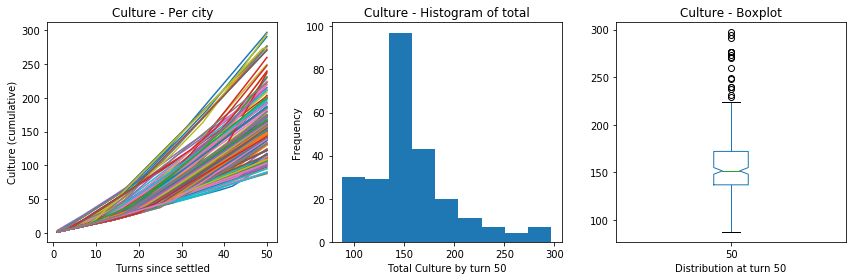


Top 10 culture cities:
        cultureTotal  culturePerTurn    settledByName  population  housing  \
cityId                                                                       
21            297.01            7.79       Wilhelmina           3        7   
189           294.72            8.92            Shaka           5        8   
51            290.64            7.77  Teddy Roosevelt           4        6   
82            276.91            7.34          Tomyris           6        8   
173           276.28            6.37    Qin Shi Huang           3        6   
188           276.28            6.37    Qin Shi Huang           3        6   
158           276.05            7.34   Jayavarman VII           6        8   
209           273.59            0.52       Poundmaker           3        5   
236           271.00            6.69        Alexander           5        6   
71            270.48            6.66        Gilgamesh           3        6   

         happiness                     

In [9]:
showYieldMetrics('Culture', 10)

## Faith


Faith:-
summary statistics:
     max: 539.01
     min: 0.00
    mean: 28.16
  median: 0.00
     std: 76.93

Quantiles:
    0.2  0.4  0.6    0.8
50  0.0  0.0  0.0  22.83




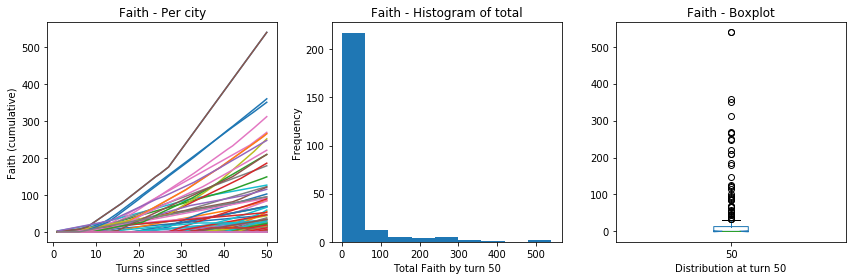


Top 10 faith cities:
        faithTotal  faithPerTurn     settledByName  population  housing  \
cityId                                                                    
161         539.01         15.82             Peter           2        8   
176         539.01         15.82             Peter           2        8   
131         359.49          9.72   Mvemba a Nzinga           5        8   
51          350.12          8.64   Teddy Roosevelt           4        6   
27          311.27         10.17             Cyrus           5        6   
7           268.84          9.04  Robert the Bruce           4        7   
97          265.19          9.27           Gitarja           6        8   
112         265.19          9.27           Gitarja           6        8   
129         251.25         11.40             Peter           5        9   
205         246.97          6.48           Gitarja           5        7   

         happiness                                       faithToolTip  
cityI

In [10]:
showYieldMetrics('Faith', 10)

## Population

7
2
4.366935483870968
4.0


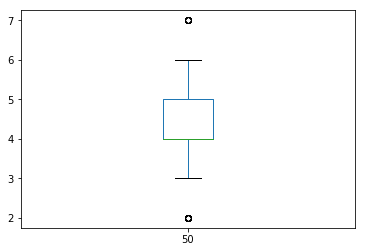

In [11]:
popDf = cityPt[['cityId', 'turns', 'population']].pivot(index='turns',
                                                        columns='cityId',
                                                        values='population')
t50 = popDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box()

In [12]:
# Code testing how to get turn next pop reached
#df = pd.DataFrame({"A": [1,2,2,2,3],
#                   "B": [1,2,2,3,3],
#                   "C": [1,2,3,3,4],
#                   "D": [1,1,1,2,2]}, index=[1,2,3,4,5])
#print(df)
#maxPop = df.max().max()
#newDf = pd.DataFrame(columns=df.columns.values.tolist(), index=range(1,maxPop+1))
#print(newDf)
#
#for i in range(1,maxPop+1):
#    for j in df.columns.values.tolist():
#        s = df[j]
#        try:
#            s = int(s[s == i].index[0])
#        except IndexError:
#            s = 0
#        newDf.loc[i,j] = s
#print(newDf.astype('int64'))

In [13]:
maxPop = popDf.max().max()
popGrowthDf = pd.DataFrame(columns=popDf.columns.values.tolist(), index=range(1, maxPop + 1))
for i in range(1,maxPop+1):
    for j in popDf.columns.values.tolist():
        s = popDf[j]
        try:
            turnNextPopReached = int(s[s == i].index[0])
        except IndexError:
            # Using NaN messes up types so using 0 to indicate never reached that pop!
            turnNextPopReached = 0
        popGrowthDf.loc[i,j] = turnNextPopReached
popGrowthDf = popGrowthDf.T.astype('int64')
print(popGrowthDf.shape)

(248, 7)


In [14]:
print("Population growth descriptive statistics:\n")
print("Columns represent the population, Rows the descriptive measure")
print("count shows the drop-off in number of city with larger population")
popGrowthStats = pd.DataFrame()
for i in popGrowthDf.columns.values.tolist():
    s = popGrowthDf.loc[:,i]
    s = s[s != 0]
    #print(s.describe())
    popGrowthStats[i] = s.describe()
print(popGrowthStats.round(1))

Population growth descriptive statistics:

Columns represent the population, Rows the descriptive measure
count shows the drop-off in number of city with larger population
           1      2      3      4      5     6     7
count  248.0  247.0  235.0  196.0  123.0  45.0  10.0
mean     1.0    8.4   19.5   29.9   37.4  42.2  45.8
std      0.0    3.3    8.8    9.8    8.0   6.2   3.2
min      1.0    2.0    6.0   14.0   21.0  28.0  41.0
25%      1.0    6.0   13.0   21.8   32.0  39.0  43.5
50%      1.0    8.0   17.0   28.5   38.0  44.0  46.5
75%      1.0    8.0   19.5   36.0   44.0  47.0  48.8
max      1.0   15.0   50.0   50.0   50.0  50.0  49.0


## Housing

11
4
7.318548387096774
7.0


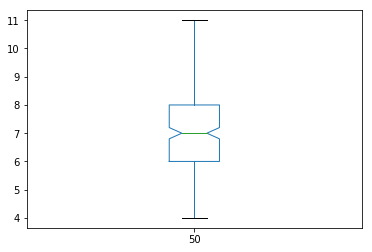

In [15]:
housingDf = cityPt[['cityId', 'turns', 'housing']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='housing')
t50 = housingDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Amenities

5
0
1.5120967741935485
1.0


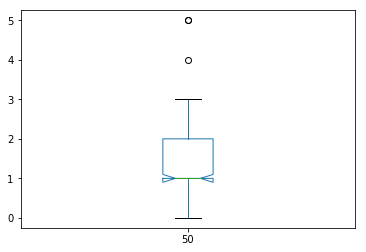

In [16]:
amenitiesDf = cityPt[['cityId', 'turns', 'amenities']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenities')
t50 = amenitiesDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

3
0
1.439516129032258
1.0


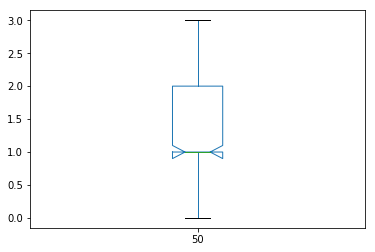

In [17]:
amenitiesNeededDf = cityPt[['cityId', 'turns', 'amenitiesNeeded']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenitiesNeeded')
t50 = amenitiesNeededDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Happiness

In [18]:
happinessDf = cityPt[['cityId', 'turns', 'happiness']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='happiness')
#print(happinessDf.shape)

happinessVals = set([])
for columnName in happinessDf.columns.values.tolist():
    vals = happinessDf[columnName].unique().tolist()
    for item in vals:
        happinessVals.add(item)
#print(happinessVals)

turnsPerHappinessValue = pd.DataFrame()
for columnName in happinessDf.columns.values.tolist():
    for val in happinessVals:
        s = happinessDf[columnName]
        turnsPerHappinessValue.loc[val, columnName] = s[s == val].count()
print("\nPer city number of turns per happiness state:")
print(turnsPerHappinessValue)
print("\nAverage number of turns per happiness state across all the cities:")
print(turnsPerHappinessValue.T.mean())




Per city number of turns per happiness state:
             1     2     3     4     5     6     7     8     9     10   ...   \
Displeased   0.0   0.0   9.0   0.0  12.0   0.0   0.0   0.0   0.0  13.0  ...    
Happy       50.0  49.0  15.0  50.0  12.0  20.0  12.0  41.0  34.0  13.0  ...    
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
Content      0.0   1.0  26.0   0.0  26.0  30.0  38.0   9.0  16.0  24.0  ...    

             239   240   241   242   243   244   245   246   247   248  
Displeased   7.0   3.0  18.0  12.0   0.0   0.0  12.0   7.0   0.0  13.0  
Happy       11.0  18.0  11.0  15.0  50.0  47.0  15.0  18.0  16.0  15.0  
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Content     32.0  29.0  21.0  23.0   0.0   3.0  23.0  25.0  34.0  22.0  

[4 rows x 248 columns]

Average number of turns per happiness state across all the cities:
Displeased     4.536290
Happy         25.334677
Ecstatic       0.056452
Content       20.072581

## Look at individual city metrics

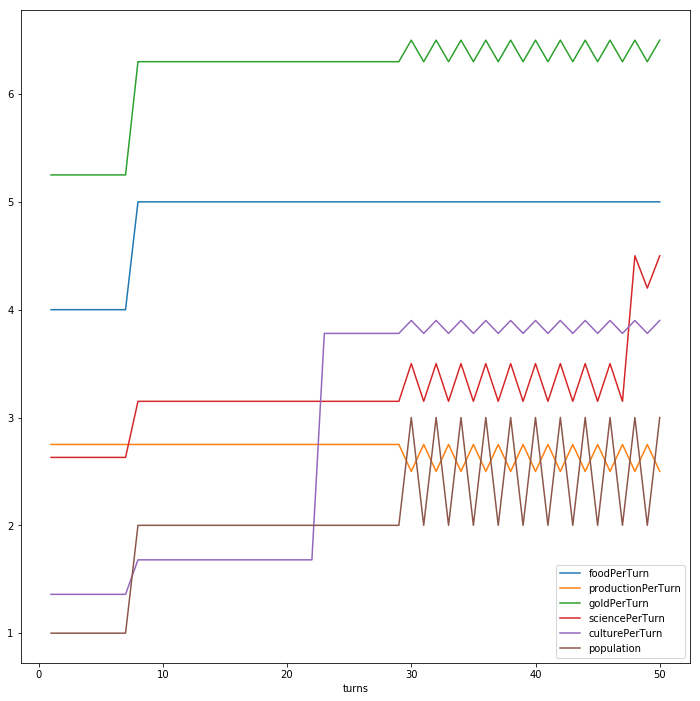

In [21]:
cityIdToGetMetrics = 200
cityData = cityPt[(cityPt.cityId == cityIdToGetMetrics)]
cityGraphData = cityData[['turns','foodPerTurn', 'productionPerTurn', 'goldPerTurn', 'sciencePerTurn', 'culturePerTurn', 'population']]
cityGraphData.set_index('turns', inplace=True)

cityGraphData.plot(kind='line', figsize=(12,12))


In [20]:
cur.close()
cnx.close()